# Julia Serial Connection
## LibSerialPort

In [33]:
using Pkg
Pkg.add("FFTW")
using PyPlot

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [1]:
using LibSerialPort
list_ports() 

/dev/ttyACM0
	Description:	USB Serial - 5870570
	Transport type:	SP_TRANSPORT_USB


## Open Serial Connection

In [2]:
sp=open("/dev/ttyACM0",9600) 

SerialPort(Ptr{LibSerialPort.SPPort} @0x0000000003373e00, false, true)

In [294]:
close(sp)

0x00

## Serial Commands
- write(sp,"b")
- bytesavailable(sp)
- read(sp,UInt8)   




## Echo Server Test

In [ ]:
# Clear buffer
while (bytesavailable(sp)>0)
    read(sp)
end

NStart=0
NEnd=255


for n = NStart:NEnd
    #a = string("",n)
    #println("writing ",UInt8(n))
    write(sp,UInt8(n))
    sleep(0.001)
end
sleep(0.1)

BytesWritten=NEnd-NStart+1

println("Bytes written ",BytesWritten)

BytesAvailable=bytesavailable(sp)
println("Bytes available:",BytesAvailable)

x=zeros(UInt8,BytesAvailable)

for n = 1:BytesAvailable
    x[n]=read(sp,UInt8)
    println(Int(x[n]))
end
    

## Sampling Test

In [29]:
# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

a = "" # Keep bytes as a string
i = 0
b=""

# Send command
BytesWritten=1
Command = "b"
write(sp,Command) # See code for command meanings
println("Command Sent ",Command)

while bytesavailable(sp) < 1
    continue # wait for a response    
end  

while true
    if bytesavailable(sp) < 1
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
     b = read(sp,UInt8) # Using read() is much slower due to extra delays
#     a = string(a,b)
    i += 1    
end

println("Sample complete")
println("Bytes recieved: ",i)



# println("Bytes written ",BytesWritten)

# BytesAvailable=bytesavailable(sp)
# println("Bytes available:",BytesAvailable)

# x=zeros(UInt8,BytesAvailable)

# for n = 1:BytesAvailable
#     x[n]=read(sp,UInt8)
#     #println(Int(x[n]))
# end


Command Sent b
Finished Reading
Sample complete
Bytes recieved: 40000


## Working Sampling Test

Command Sent b


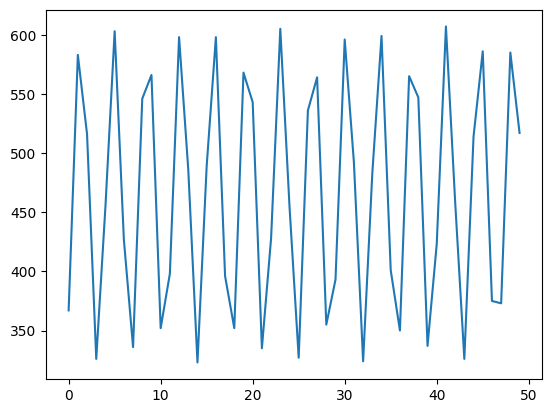

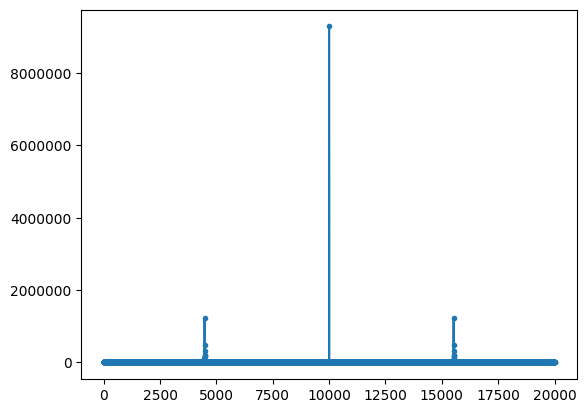

Finished Reading
Sample complete
Bytes recieved: 40000


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb963c8898>

In [302]:
# set number of samples
S = 20000

# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

a = "" # Keep bytes as a string
i = 1
b=""

x=zeros(UInt8,S*2)

# Send command
BytesWritten=1
Command = "b"
write(sp,Command) # See code for command meanings
println("Command Sent ",Command)

while bytesavailable(sp) < 1
    continue # wait for a response    
end  

while true
    if bytesavailable(sp) < 1
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
    x[i]=read(sp,UInt8)
#      b = read(sp,UInt8) # Using read() is much slower due to extra delays
#     a = string(a,b)
    i += 1    
end

println("Sample complete")
RecievedBytes=i-1
println("Bytes recieved: ",RecievedBytes)

x_rx=zeros(UInt16,S)
i = 1
for n = 1:S
    x_rx[n]=(UInt16(x[i])<<8 | UInt16(x[i+1]))
    i+=2
end

time = read(sp,UInt8)
figure()
plot(x_rx[1:50])
using FFTW
X = fft(x_rx)
figure()
plot(fftshift(abs.(X)),".-")

In [301]:
write(sp,"t")
sleep(0.1)
# timeMicro = read(sp,Int)
timeMicro = parse(Int,readline(sp) )
timeMilli = timeMicro*10^-3
time = timeMicro*10^-6
sampleRate = S/(time)
println("Time to sample " ,timeMilli, "(ms)")
println("Sample rate " ,sampleRate)

Time to sample 138.04400000000004(ms)
Sample rate 144881.3421807539


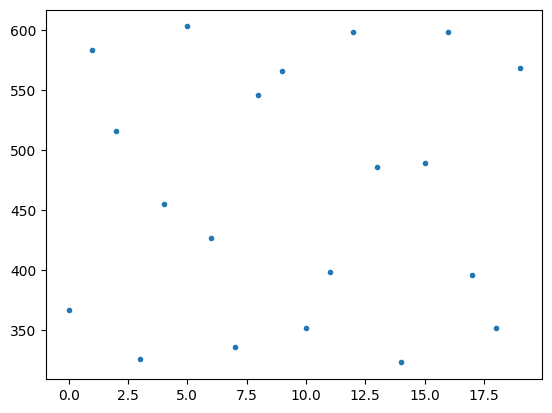

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb96d8aa20>

In [306]:
plot(x_rx[1:20],".")

In [5]:
bytesavailable(sp)

4095

In [ ]:
using Pkg
Pkg.add("FFTW")
using PyPlot

## DMA Sampling

Conversion complete in 20000 us


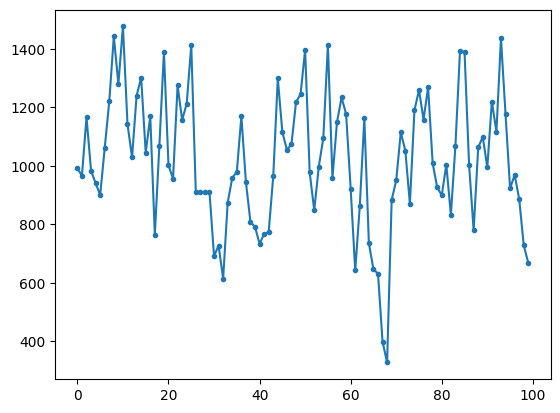

Finished Reading
Number of bytes received 20000


In [46]:
N=20000 #Number of samples expected
data = String[]
i =1

# Clear buffer
while (bytesavailable(sp)>0)
    read(sp,UInt8)
end

# Start a conversion
write(sp,"c")

while bytesavailable(sp) < 1
    continue # wait for a response    
end  
sleep(0.05) # This extra delay helps with reliability - it gives the micro time to send all it needs to

time = read(sp,String)
print(time) 

x_rx=zeros(Int16,N)

# Get the values
write(sp,"p") # Print DMA buffer
while bytesavailable(sp) < 1
    continue # wait for a response    
end  

while true
     if bytesavailable(sp) < 1
        sleep(0.050) # Wait and check again
        if bytesavailable(sp) < 1
            println("Finished Reading")
            break
        end
    end
    x_rx[i]=(parse(Int16,(readline(sp))))
    i += 1
    
end

println("Number of bytes received ", i-1)

figure()
plot(x_rx[1:100],".-")
show()

In [27]:
using PyPlot

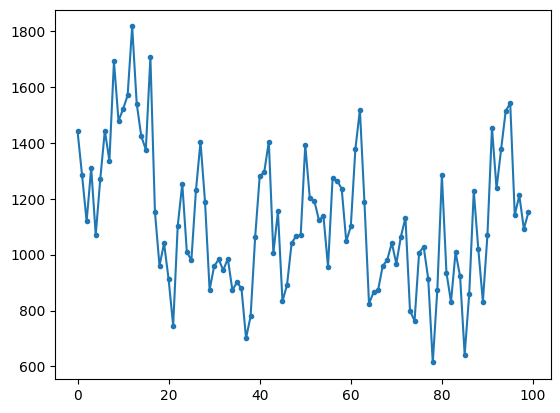

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5803a6fdd8>

In [32]:
figure()
plot(x_rx[1:100],".-")

## Continuous Sampling

In [59]:
N=20000 #Number of samples expected
for n in 1:10
    data = String[]
    i =1

    # Clear buffer
    while (bytesavailable(sp)>0)
        read(sp,UInt8)
    end

    # Start a conversion
    write(sp,"c")

    while bytesavailable(sp) < 1
        continue # wait for a response    
    end  
    sleep(0.001) # This extra delay helps with reliability - it gives the micro time to send all it needs to

    time = read(sp,String)
    print(time) 

    x_rx=zeros(Int16,N)

    # Get the values
    write(sp,"p") # Print DMA buffer
    while bytesavailable(sp) < 1
        continue # wait for a response    
    end  

    while true
         if bytesavailable(sp) < 1
            sleep(0.050) # Wait and check again
            if bytesavailable(sp) < 1
                break
            end
        end
        x_rx[i]=(parse(Int16,(readline(sp))))
        i += 1

    end

    println("Number of bytes received ", i-1)
 
end

print("Done")

Conversion complete in 20000 us
Number of bytes received 20000
Conversion complete in 20001 us
Number of bytes received 20000
Conversion complete in 20000 us
Number of bytes received 20000
Conversion complete in 20001 us
Number of bytes received 20000
Conversion complete in 20001 us
Number of bytes received 20000
Conversion complete in 20000 us
Number of bytes received 20000
Conversion complete in 20000 us
Number of bytes received 20000
Conversion complete in 20001 us
Number of bytes received 20000
Conversion complete in 20000 us
Number of bytes received 20000
Conversion complete in 20000 us
Number of bytes received 20000
Done

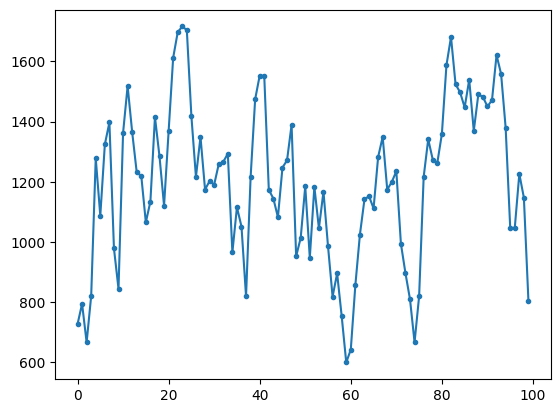

In [60]:
a= figure()
b = plot(x_rx[1:100],".-")  
show()